In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns

# Author: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
# License: BSD (3-clause)
from matplotlib.colors import TwoSlopeNorm

import os.path as op
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

from mne_connectivity import spectral_connectivity_epochs, seed_target_indices
from mne.datasets import sample
from mne_connectivity.viz import plot_sensors_connectivity
from mne.stats import permutation_cluster_test
from scipy import stats as stats
from functools import partial

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
dict015= {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FT9':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg','FT10':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','TP9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','TP10':'eeg','P7':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_imp = {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','FT9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','FT10':'eeg','TP9':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_exp = dict015

dict011_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg','T7':'eeg','FT10':'eeg',
               'CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'FT9':'eeg', 'TP10':'eeg','P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg',
               'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
              'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict011_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FT10':'eeg', 'FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
               'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'TP9':'eeg', 'P8':'eeg','P4':'eeg','Pz':'eeg',
               'P3':'eeg','P7':'eeg','O2':'eeg', 'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs',
               'DBS6-7':'dbs','DBS7-8':'dbs', 'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}
           
    
#'DBS1-234':'dbs','DBS234-567':'dbs','DBS567-8':'dbs','mean(DBS1-234, DBS234-567, DBS567-8)':'dbs',

dict08_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                  'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                  'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',             
              'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict08_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FC6':'eeg', 'FC2':'eeg','FC1':'eeg','FC5':'eeg',
              'T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg', 'T7':'eeg','FT10':'eeg', 'CP6':'eeg','CP2':'eeg',
              'CP1':'eeg','CP5':'eeg','FT9':'eeg','TP10':'eeg', 'P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg',
              'O2':'eeg','O1':'eeg',
                  'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                  'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',         
              'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_imp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                  'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                  'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',
             'DynR':'misc','DynL':'misc','DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_exp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P8':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg','O1':'eeg',
                  'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                  'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',         
             'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict_eog= {'FP1':'eog'}

In [3]:
base_dir = "E:/Oddball Data/"
subj_list = ['007','008','011','013','014','015']
subj_list = ['008']

stage = ['implant']#, 'implant']explant
aff_cond = ['1', '101'];
aff_cond_plot = ['Standard', 'Oddball'];

naff_cond = ['10', '110'];

for sub in subj_list:
    for st in stage:
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        fname = data_dir+"data_clean"+st+'.mat'
                
        if sub == '015' or sub=='014':
            dict1 = dict015
        elif sub == '013' and st== 'implant':
            dict1 = dict013_imp
        elif sub == '013' and st== 'explant':
            dict1 = dict013_exp
        elif sub == '011' and st== 'implant':
            dict1 = dict011_imp
        elif sub == '011' and st== 'explant':
            dict1 = dict011_exp
        elif sub == '008' and st== 'implant':
            dict1 = dict08_imp
        elif sub == '008' and st== 'explant':
            dict1 = dict08_exp
        elif sub == '007' and st== 'implant':
            dict1 = dict07_imp
        elif sub == '007' and st== 'explant':
            dict1 = dict07_exp

        info = mne.create_info(list(dict1.keys()), sfreq=200, ch_types='misc', verbose=None)
        epochs = mne.read_epochs_fieldtrip(fname,info,data_name='x', trialinfo_column=0)
        
        sfreq = epochs.info['sfreq']
        
        epochs.set_channel_types(dict1)

        kind='easycap-M1'
        mon = mne.channels.make_standard_montage(kind, head_size='auto')
        epochs.set_montage(mon,match_case=False, on_missing='ignore')
        
        epochs.filter(0.1,30)

        epochs_aff_odd = epochs[aff_cond[1]]
        epochs_aff_typ = epochs[aff_cond[0]]

        mne.epochs.equalize_epoch_counts([epochs_aff_odd,epochs_aff_typ], method='truncate')
        
        epochs_aff_odd.set_channel_types(dict_eog)
        epochs_aff_typ.set_channel_types(dict_eog)

Adding metadata with 9 columns
431 matching events found
No baseline correction applied
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\2360165014.py:40: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, Pz, T7, T8, TP10, TP9 has changed from NA to V.
  epochs.set_channel_types(dict1)
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\2360165014.py:46: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(0.1,30)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 6

Dropped 0 epochs: 
Dropped 103 epochs: 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152


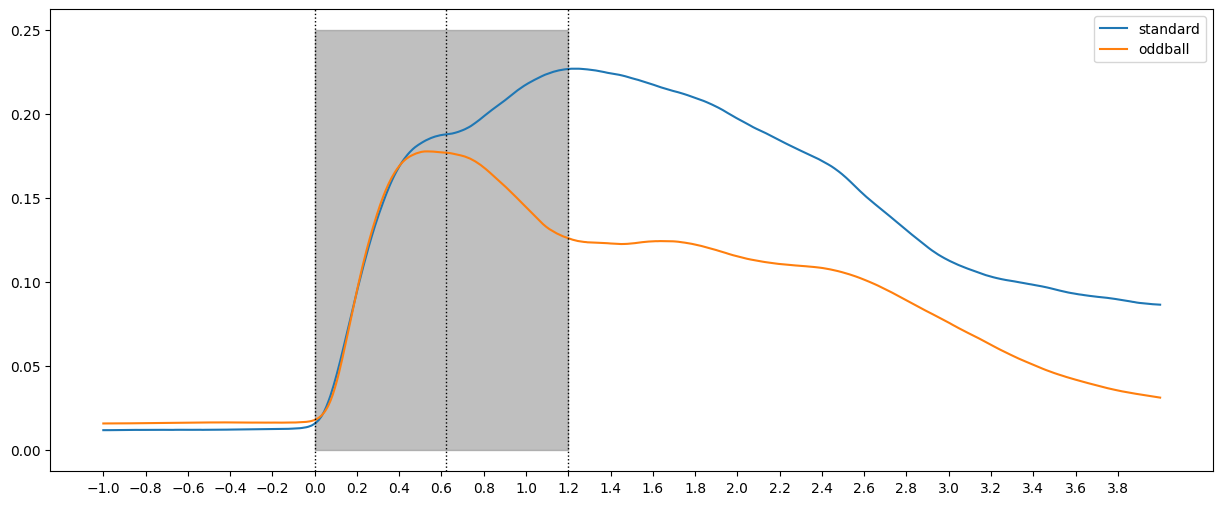

In [4]:
tmax = 4
Dynmo_odd = epochs_aff_odd.copy().crop(-1,tmax).get_data(picks='DynL(lc)')
Dynmo_odd= Dynmo_odd.reshape(Dynmo_odd.shape[0],Dynmo_odd.shape[2]).mean(axis=0)

Dynmo_typ = epochs_aff_typ.copy().crop(-1,tmax).get_data(picks='DynL(lc)')
Dynmo_typ= Dynmo_typ.reshape(Dynmo_typ.shape[0],Dynmo_typ.shape[2]).mean(axis=0)

plt.figure(figsize=(15,6))

time= epochs_aff_typ.copy().crop(-1,tmax).times

plt.plot(epochs_aff_typ.copy().crop(-1,tmax).times,Dynmo_typ)
plt.plot(epochs_aff_odd.copy().crop(-1,tmax).times,Dynmo_odd)

x=np.arange(-1,tmax,0.2)

plt.xticks(x)
idx = np.argwhere(np.diff(np.sign(Dynmo_typ - Dynmo_odd))).flatten()

plt.axvline(0, linewidth=1, color="black", linestyle=":")

plt.axvline(0.62, linewidth=1, color="black", linestyle=":")
plt.axvline(1.2, linewidth=1, color="black", linestyle=":")
plt.fill_betweenx(np.array((0,0.25)), 1.2,0,color='gray', alpha=0.5)

plt.legend(['standard','oddball'])

# Event-Related Potentials

In [ ]:
vmin,vmax= -15e6, 15e6
vmin1,vmax1= -35e6, 35e6
time_ranges_of_interest = [(0.0, 1)]

evoked_odd = epochs_aff_odd.average()
evoked_typ = epochs_aff_typ.average()
evoked_odd.apply_baseline((-2,-1))
evoked_typ.apply_baseline((-2,-1))
evoked_odd.plot(spatial_colors=True, gfp=True, highlight=time_ranges_of_interest, ylim =dict(eeg=[vmin,vmax],dbs=[vmin1,vmax1]))
evoked_typ.plot(spatial_colors=True, gfp=True, highlight=time_ranges_of_interest, ylim= dict(eeg=[vmin,vmax],dbs=[vmin1,vmax1]))

In [ ]:
mne.viz.plot_compare_evokeds(
    dict(standard=evoked_typ,oddball=evoked_odd),
    legend="upper left",
    show_sensors="upper right",
)

In [ ]:
mne.viz.plot_compare_evokeds(
    dict(standard=evoked_typ.copy().pick(['CP2','C4','FC2']),oddball=evoked_odd.copy().pick(['CP2','C4','FC2'])),
    legend="upper left",
    show_sensors="upper right",
)

In [ ]:
cmin,cmax= -5e6, 5e6
if sub =="015":
    fig1 = evoked_odd.plot_topomap(times=[-0.2, 0, 0.1, 0.2, 0.3, 0.4, time[idx][0],  0.8, 1, 1.2], vlim=(cmin,cmax))
    fig2 = evoked_typ.plot_topomap(times=[-0.2, 0, 0.1, 0.2, 0.3, 0.4, time[idx][0],  0.8, 1, 1.2], vlim=(cmin,cmax))
else:
    fig1 = evoked_odd.plot_topomap(times=[-0.2, 0, 0.1, 0.3, 0.4, 0.5, 0.6, 0.8, 1.2, 1.5], vlim=(cmin,cmax))
    fig2 = evoked_typ.plot_topomap(times=[-0.2, 0, 0.1, 0.3, 0.4, 0.5 ,0.6, 0.8, 1.2, 1.5], vlim=(cmin,cmax))

In [ ]:
# for filter wise plots
#bands= {'theta':(4,8),'alpha':(8,13), 'beta': (13,30)}
#vmin,vmax= -1e6, 1e6

#for key, val in bands.items():
#    ev_odd = evoked_odd.copy().filter(val[0],val[1])
#    ev_typ = evoked_typ.copy().filter(val[0],val[1])
    
#    fig1 = ev_odd.plot_topomap(times=[-0.2, 0, 0.1, 0.3, 0.4, 0.5, 0.6, 0.8, 1.2, 1.5], vlim=(vmin,vmax))
#    fig2 = ev_typ.plot_topomap(times=[-0.2, 0, 0.1, 0.3, 0.4, 0.5 ,0.6, 0.8, 1.2, 1.5], vlim=(vmin,vmax))

In [ ]:
topomap_args = dict(vlim=(vmin,vmax))
#ts_args = 

evoked_odd.copy().crop(-0.5,1.5).pick('eeg').plot_joint()
evoked_typ.copy().crop(-0.5,1.5).pick('eeg').plot_joint()

In [ ]:
evoked_odd.copy().crop(-0.5,1.5).pick(['FC2','C4','CP2']).plot_joint()
evoked_typ.copy().crop(-0.5,1.5).pick(['FC2','C4','CP2']).plot_joint()

In [ ]:
vmin,vmax=-15e6,15e6
evoked_odd.copy().crop(-0.5,1.5).pick(['C3','FC2','C4','CP2']).plot(spatial_colors=True, gfp=True, highlight=time_ranges_of_interest,ylim =dict(eeg=[vmin,vmax]))
evoked_typ.copy().crop(-0.5,1.5).pick(['C3','FC2','C4','CP2']).plot(spatial_colors=True, gfp=True, highlight=time_ranges_of_interest,ylim =dict(eeg=[vmin,vmax]))

In [ ]:
evoked_odd.copy().crop(-0.5,1.5).pick(['dbs']).plot(spatial_colors=True, gfp=True, highlight=time_ranges_of_interest,ylim =dict(dbs=[vmin1,vmax1]))
evoked_typ.copy().crop(-0.5,1.5).pick(['dbs']).plot(spatial_colors=True, gfp=True, highlight=time_ranges_of_interest,ylim =dict(dbs=[vmin1,vmax1]))

In [ ]:
epochs_aff_odd.plot_image(picks=["C4", "FC2",'CP2'])

# Time freq Analysis

In [5]:
tmin, tmax = -1, 4
freqs = np.arange(1, 30)  # frequencies from 2-100Hz

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

epochs_dbs = [epochs_aff_typ.copy().pick(['dbs']), epochs_aff_odd.copy().pick(['dbs'])]

epochs = [epochs_aff_typ.copy().pick(['eeg']), epochs_aff_odd.copy().pick(['eeg'])]

#del epochs_aff_typ, epochs_aff_odd

tfrs = []
for i, epoch in enumerate(epochs):
    
    """tfrs1 = mne.time_frequency.tfr_morlet(epoch, freqs=freqs, n_cycles=5,average=False, return_itc=False)
    """
    tfrs1 = tfr_multitaper(
            epoch,
            freqs=freqs,
            n_cycles=7,
            use_fft=True,
            return_itc=False,
            average=False,
            decim=2,
            n_jobs=None
        )
    tfrs1.crop(tmin, tmax)
    # tfr_data = tfrs1.data
    tfr_data = 10*np.log10(tfrs1.data) # applying log transformation 

    """Average Baseline"""       
    tfr_norm1 =[] 
    for ii,ch in enumerate(tfrs1.ch_names):
        x = np.hstack(tfr_data[:, ii, :, :]) # 3D dim = epoch* freq* time to 2D dim, freq * (time *epoch)
        x_mean=x.mean(axis=1) # mean of all the freqs across all the complete experiment session.
        tfr_norm=[]    
        for j in range(tfr_data[:, ii, :, :].shape[0]):
            tfr_norm.append(((tfr_data[j, ii, :, :].T-x_mean)/x_mean).T) # applying normalaization on each trail

        tfr_norm1.append(tfr_norm)
    tfr_norm1 = np.array(tfr_norm1)
    tfr_norm1 = np.rollaxis(tfr_norm1,1) # normalized tfr data
    
    
    event_id = dict( Standard=1,Oddball=101)
    tfrs1 = mne.time_frequency.EpochsTFR(tfrs1.info, tfr_norm1, tfrs1.times, tfrs1.freqs,comment=aff_cond_plot[i],events=epoch.events,event_id=event_id) 
    tfrs.append(tfrs1)

    
tfrs_dbs = []
for i, epoch in enumerate(epochs_dbs):
    
    tfrs1_dbs = tfr_multitaper(
            epoch,
            freqs=freqs,
            n_cycles=7,
            use_fft=True,
            return_itc=False,
            average=False,
            decim=2,
        )
    tfrs1_dbs.crop(tmin, tmax)

    #tfr_data = tfrs1_dbs.data
    tfr_data = 10*np.log10(tfrs1_dbs.data) # applying log transformation 
    
    """Average Baseline"""       
       
    tfr_norm1 =[] 
    for ii,ch in enumerate(tfrs1_dbs.ch_names):
        x = np.hstack(tfr_data[:, ii, :, :]) # 3D dim = epoch* freq* time to 2D dim, freq * (time *epoch)
        x_mean=x.mean(axis=1) # mean of all the freqs across all the complete experiment session.
        tfr_norm=[]    
        for j in range(tfr_data[:, ii, :, :].shape[0]):
            tfr_norm.append(((tfr_data[j, ii, :, :].T-x_mean)/x_mean).T) # applying normalaization on each trail

        tfr_norm1.append(tfr_norm)
    tfr_norm1 = np.array(tfr_norm1)
    tfr_norm1 = np.rollaxis(tfr_norm1,1) # normalized tfr data
 
    
    tfrs1_dbs = mne.time_frequency.EpochsTFR(tfrs1_dbs.info, tfr_norm1, tfrs1_dbs.times, tfrs1_dbs.freqs,comment=aff_cond_plot[i],events=epoch.events,event_id=event_id)
    tfrs_dbs.append(tfrs1_dbs)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   21.1s


Adding metadata with 9 columns
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   21.2s


Adding metadata with 9 columns
Not setting metadata
Adding metadata with 9 columns
Not setting metadata
Adding metadata with 9 columns
Not setting metadata


In [6]:
vmin, vmax = -0.5, 0.5  # set min and max ERDS values in plot
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
if subj_list == ['013'] or subj_list == ['014'] or subj_list == ['015']:
    ch_picks =['F4','F8','FC2','FC6','C4','CP2','CP6','P4']
else:
    ch_picks =['F8','F4','FC6','FC2','C4','CP6','CP2','P4']

for n, tfr in enumerate(tfrs):
    chs =[]
    for i, ch_name in enumerate(epochs[n].info.ch_names):
        if  ch_name in ch_picks: 
            chs.append(i)
    
    width_ratios=[10]*len(chs)
    width_ratios.extend([1])
    
    fig, axes = plt.subplots(
            1, len(chs)+1, figsize=(22, 3), gridspec_kw={"width_ratios": width_ratios}
        )
    # positive clusters
    for ch, ax in enumerate(axes[:-1]):

        tfr.average().plot(
                    [epochs[n].info.ch_names[chs[ch]]],
                    axes=ax,
                    colorbar=False,
                    cnorm=cnorm,
                    show=False,
                    mask_style="mask",
                )
        ax.set_title(epochs[0].info.ch_names[chs[ch]], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS - {aff_cond_plot[n]}")

No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1305743471.py:23: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


In [7]:
vmin, vmax = -0.6, 0.6 # set min and max ERDS values in plot
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

for n, tfr in enumerate(tfrs):
    chs =[]
    for i, ch_name in enumerate(epochs[n].info.ch_names):
        if  ch_name in ch_picks: 
            chs.append(i)
    
    width_ratios=[10]*len(chs)
    width_ratios.extend([1])
    
    fig, axes = plt.subplots(
            1, len(chs)+1, figsize=(22, 3), gridspec_kw={"width_ratios": width_ratios}
        )
    
    # positive clusters
    for ch, ax in enumerate(axes[:-1]):
        _, c1, p1, _ = pcluster_test(tfrs[n].data[:, chs[ch]], tail=1, **kwargs)
            # negative clusters
        _, c2, p2, _ = pcluster_test(tfrs[n].data[:, chs[ch]], tail=-1, **kwargs)
        
                # note that we keep clusters with p <= 0.05 from the combined clusters
                # of two independent tests; in this example, we do not correct for
                # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values

        mask = c[..., p <= 0.05].any(axis=-1)
        # plot TFR (ERDS map with masking)
        tfr.average().plot(
                    [epochs[n].info.ch_names[chs[ch]]],
                    axes=ax,
                    colorbar=False,
                    cnorm=cnorm,
                    show=False,
                    mask = mask,
                    mask_style="mask",
                )
        ax.set_title(epochs[0].info.ch_names[chs[ch]], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS - {aff_cond_plot[n]}")

Using a threshold of 1.676551
stat_fun(H1): min=-2.573147 max=3.131551
Running initial clustering …
Found 20 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-2.573147 max=3.131551
Running initial clustering …
Found 20 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-3.060434 max=3.133160
Running initial clustering …
Found 27 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-3.060434 max=3.133160
Running initial clustering …
Found 19 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-2.678691 max=4.715332
Running initial clustering …
Found 19 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-2.678691 max=4.715332
Running initial clustering …
Found 19 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-3.006343 max=4.016427
Running initial clustering …
Found 20 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-3.006343 max=4.016427
Running initial clustering …
Found 20 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-3.638890 max=4.933236
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-3.638890 max=4.933236
Running initial clustering …
Found 23 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-3.333956 max=5.304525
Running initial clustering …
Found 22 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-3.333956 max=5.304525
Running initial clustering …
Found 17 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-7.356440 max=6.667956
Running initial clustering …
Found 29 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-7.356440 max=6.667956
Running initial clustering …
Found 16 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-5.310836 max=5.449165
Running initial clustering …
Found 41 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-5.310836 max=5.449165
Running initial clustering …
Found 16 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-3.480581 max=4.007214
Running initial clustering …
Found 11 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-3.480581 max=4.007214
Running initial clustering …
Found 16 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-3.256930 max=3.186442
Running initial clustering …
Found 30 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-3.256930 max=3.186442
Running initial clustering …
Found 22 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-4.084184 max=3.910363
Running initial clustering …
Found 34 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-4.084184 max=3.910363
Running initial clustering …
Found 18 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-3.432771 max=5.450492
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-3.432771 max=5.450492
Running initial clustering …
Found 15 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-3.501020 max=5.432092
Running initial clustering …
Found 10 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-3.501020 max=5.432092
Running initial clustering …
Found 14 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-5.060937 max=5.463534
Running initial clustering …
Found 18 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-5.060937 max=5.463534
Running initial clustering …
Found 10 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-7.842931 max=7.744980
Running initial clustering …
Found 55 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-7.842931 max=7.744980
Running initial clustering …
Found 15 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-5.613918 max=6.931851
Running initial clustering …
Found 34 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-5.613918 max=6.931851
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_1339180\1376156941.py:17: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr.average().plot(


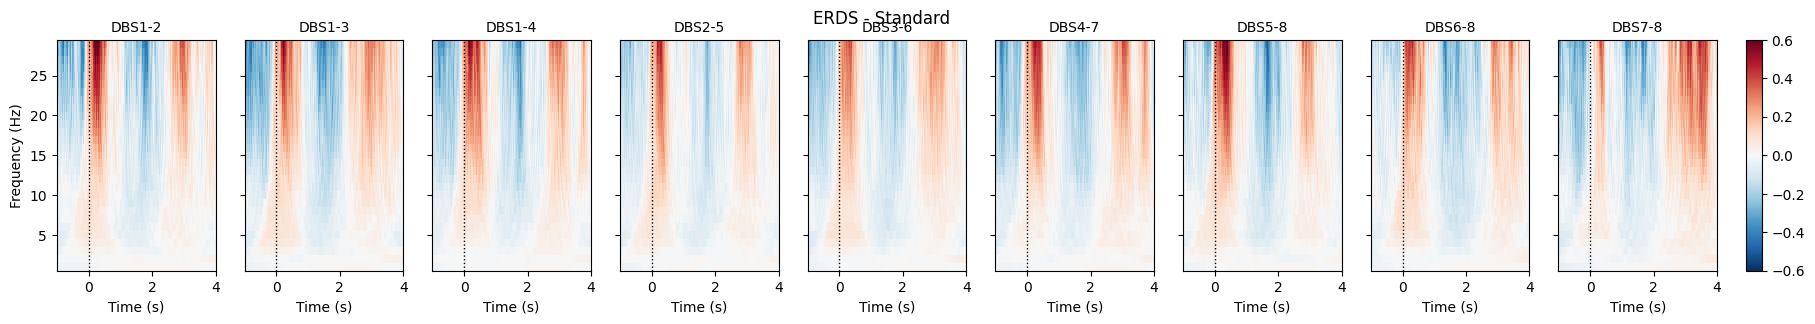

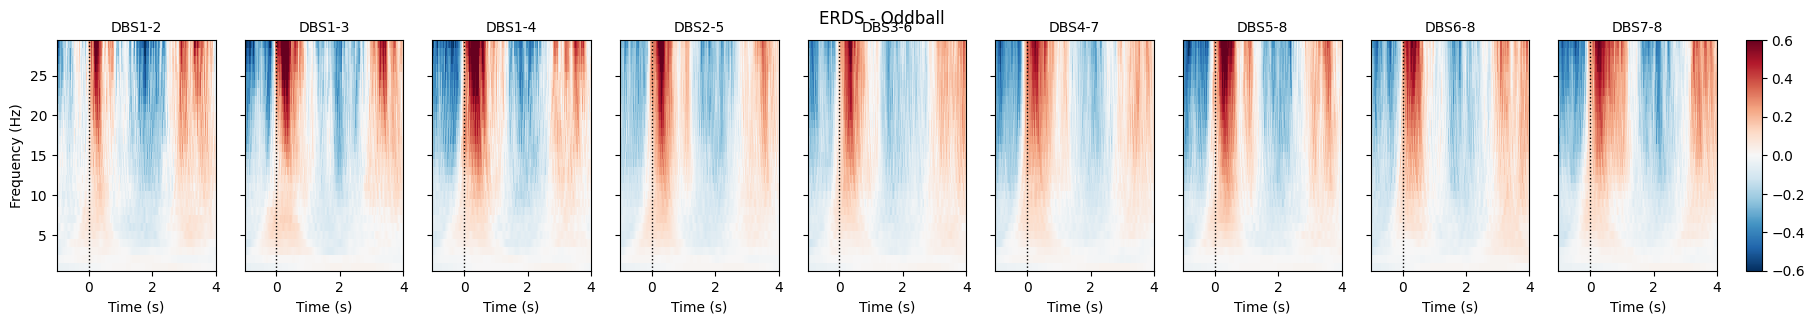

In [8]:
vmin, vmax = -0.6, 0.6  # set min and max ERDS values in plot
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    
for n, tfr in enumerate(tfrs_dbs):
    chs = list(range(0, len(epochs_dbs[0].info.ch_names)))
    
    width_ratios=[10]*len(chs)
    width_ratios.extend([1])
    
    fig, axes = plt.subplots(
            1, len(chs)+1, figsize=(22, 3), gridspec_kw={"width_ratios": width_ratios}
        )
    # positive clusters
    for ch, ax in enumerate(axes[:-1]):

        # plot TFR (ERDS map with masking)
        tfr.average().plot(
                    [epochs_dbs[n].info.ch_names[chs[ch]]],
                    axes=ax,
                    colorbar=False,
                    cnorm=cnorm,
                    show=False,
                    mask_style="mask",
                )
        ax.set_title(epochs_dbs[0].info.ch_names[chs[ch]], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS - {aff_cond_plot[n]}")

In [ ]:
vmin, vmax = -0.5, 0.5  # set min and max ERDS values in plot
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    
for n, tfr in enumerate(tfrs_dbs):
    chs = list(range(0, len(epochs_dbs[0].info.ch_names)))
    
    width_ratios=[10]*len(chs)
    width_ratios.extend([1])
    
    fig, axes = plt.subplots(
            1, len(chs)+1, figsize=(22, 3), gridspec_kw={"width_ratios": width_ratios}
        )
    # positive clusters
    for ch, ax in enumerate(axes[:-1]):
        _, c1, p1, _ = pcluster_test(tfrs_dbs[n].data[:, chs[ch]], tail=1, **kwargs)
            # negative clusters
        _, c2, p2, _ = pcluster_test(tfrs_dbs[n].data[:, chs[ch]], tail=-1, **kwargs)
        
                # note that we keep clusters with p <= 0.05 from the combined clusters
                # of two independent tests; in this example, we do not correct for
                # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values

        mask = c[..., p <= 0.05].any(axis=-1)
        # plot TFR (ERDS map with masking)
        tfrs_dbs[n].average().plot(
                    [epochs_dbs[n].info.ch_names[chs[ch]]],
                    axes=ax,
                    colorbar=False,
                    cnorm=cnorm,
                    show=False,
                    mask = mask,
                    mask_style="mask",
                )
        ax.set_title(epochs_dbs[0].info.ch_names[chs[ch]], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS - {aff_cond_plot[n]}")

Using a threshold of 1.676551
stat_fun(H1): min=-4.052614 max=5.125437
Running initial clustering …
Found 15 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-4.052614 max=5.125437
Running initial clustering …
Found 48 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-4.255318 max=5.323031
Running initial clustering …
Found 35 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-4.255318 max=5.323031
Running initial clustering …
Found 15 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-4.607965 max=5.531620
Running initial clustering …
Found 33 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-4.607965 max=5.531620
Running initial clustering …
Found 29 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-3.870001 max=5.366402
Running initial clustering …
Found 18 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-3.870001 max=5.366402
Running initial clustering …
Found 39 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-4.843355 max=4.112700
Running initial clustering …
Found 28 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-4.843355 max=4.112700
Running initial clustering …
Found 43 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-5.503305 max=5.217140
Running initial clustering …
Found 34 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-5.503305 max=5.217140
Running initial clustering …
Found 26 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-5.822750 max=5.015684
Running initial clustering …
Found 15 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-5.822750 max=5.015684
Running initial clustering …
Found 27 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-6.187695 max=4.405706
Running initial clustering …
Found 31 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-6.187695 max=4.405706
Running initial clustering …
Found 20 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-4.036068 max=3.620699
Running initial clustering …
Found 39 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-4.036068 max=3.620699
Running initial clustering …
Found 34 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-4.204230 max=2.890733
Running initial clustering …
Found 27 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-4.204230 max=2.890733
Running initial clustering …
Found 26 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-4.293942 max=4.140392
Running initial clustering …
Found 25 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-4.293942 max=4.140392
Running initial clustering …
Found 32 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-3.573514 max=3.995014
Running initial clustering …
Found 18 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-3.573514 max=3.995014
Running initial clustering …
Found 41 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-3.492557 max=6.035021
Running initial clustering …
Found 18 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-3.492557 max=6.035021
Running initial clustering …
Found 24 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-4.689692 max=6.077167
Running initial clustering …
Found 47 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-4.689692 max=6.077167
Running initial clustering …
Found 35 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-5.272623 max=5.801007
Running initial clustering …
Found 19 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.676551
stat_fun(H1): min=-5.272623 max=5.801007
Running initial clustering …
Found 19 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.676551
stat_fun(H1): min=-4.532265 max=5.585895
Running initial clustering …
Found 43 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

In [ ]:
df1 = tfrs[0].copy().pick(ch_picks).to_data_frame(time_format=None, long_format=True)
df2 = tfrs[1].copy().pick(ch_picks).to_data_frame(time_format=None, long_format=True)
frames = [df1, df2]
df = pd.concat(frames)
# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 30, "gamma": 90}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["theta", "alpha", "beta"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:
# df["channel"] = df["channel"].cat.reorder_categories(('F4','Fz','F3','FC2','FC1','C3','Cz','C4','CP2','CP1'), ordered=True)

df["channel"] = df["channel"].cat.reorder_categories((ch_picks), ordered=True)


g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None,None))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

In [ ]:
df1 = tfrs_dbs[0].to_data_frame(time_format=None, long_format=True)
df2 = tfrs_dbs[1].to_data_frame(time_format=None, long_format=True)
frames = [df1, df2]
df = pd.concat(frames)
# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 30, "gamma": 90}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["theta", "alpha", "beta"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:

#df["channel"] = df["channel"].cat.reorder_categories(('FC2','C4','CP2'), ordered=True)

g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, None))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

In [ ]:
df1 = tfrs_dbs[0].copy().pick(['DBS5-8','DBS6-8']).to_data_frame(time_format=None, long_format=True)
df2 = tfrs_dbs[1].copy().pick(['DBS5-8','DBS6-8']).to_data_frame(time_format=None, long_format=True)
frames = [df1, df2]
df = pd.concat(frames)
# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 30, "gamma": 90}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["beta"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:

df["channel"] = df["channel"].cat.reorder_categories(('DBS5-8','DBS6-8'), ordered=True)

g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, None))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

Plots

In [ ]:
base_dir = "E:/Oddball Data/"
subj_list=['007','008','011','013','014','015']

subj_list=['007']

stage=['implant']
aff_cond=['1', '101'];
naff_cond=['10', '110'];

# layout
xy = pd.read_csv(base_dir+"xy_pos_layout.csv")
xy = np.array(xy)
ch_names = ['FP1','FP2','AF7','AF3','AFz','AF4','AF8','F7','F3','Fz','F4','F8','FT9','FC5','FC1',
'FC2','FC6','FT10','T7','C3','Cz','C4','T8','TP9','TP10','CP5','CP1''CP2','CP6','P7','P3','Pz','P4',
'P8','O1','O2','COMNT','SCALE']

layout=mne.channels.generate_2d_layout(xy, w=0.12, h=0.1, pad=0.02, ch_names=ch_names, ch_indices=None, name='eeg', bg_image=None, normalize=True)

tfr_dif=[]
tfr_contrast=[]

for sub in subj_list:
    for st in stage:
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        if sub == '015' or sub=='014' or sub=='013' or sub=='011':
            seed_chs = ['DBS1-2','DBS2-3','DBS3-4','DBS4-5','DBS5-6','DBS6-7','DBS7-8','mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)']
        elif sub =='007' or sub == '008':
            seed_chs = ['DBS1-234','DBS234-567','DBS567-8', 'mean(DBS1-234, DBS234-567, DBS567-8)']
        
        for seed_ch in seed_chs:
            tfr_odd = mne.time_frequency.read_tfrs(data_dir+ 'tfr_odd'+st+seed_ch+'-tfr.h5')
            tfr_typ = mne.time_frequency.read_tfrs(data_dir+ 'tfr_typ'+st+seed_ch+'-tfr.h5')
            tfr_dif.append(tfr_odd[0]-tfr_typ[0])
            tfr_contrast.append(mne.combine_evoked([tfr_odd[0], tfr_typ[0]], weights=[1, -1]))

In [ ]:
tfr_contrast

In [ ]:
tfr_contrast[0].plot_joint(tmin=-1, tmax=4, timefreqs=[(0.5, 10), (1.3, 8)])


In [ ]:
vmax,vmin=0.2,0
tmax= 4
fmin = 4
from matplotlib.colors import TwoSlopeNorm

Dbs_name = ['DBS1-2','DBS2-3','DBS3-4','DBS4-5','DBS5-6','DBS6-7','DBS7-8']
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0.15, vmax=vmax)

tfr_contrast[0].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[0]+' vs FC2',layout =layout,cnorm=cnorm)
tfr_contrast[0].plot('C4', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[0]+' vs C4',layout =layout,cnorm=cnorm)
tfr_contrast[0].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[0]+' vs CP2',layout =layout,cnorm=cnorm)

tfr_contrast[1].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title= Dbs_name[1]+' vs  FC2',layout =layout,cnorm=cnorm)
tfr_contrast[1].plot('C4', fmin=4, tmin=-1,tmax=tmax, title= Dbs_name[1]+' vs  C4',layout =layout,cnorm=cnorm)
tfr_contrast[1].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title= Dbs_name[1]+' vs  CP2',layout =layout,cnorm=cnorm)

tfr_contrast[2].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[2]+' vs  FC2',layout =layout,cnorm=cnorm)
tfr_contrast[2].plot('C4', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[2]+' vs C4',layout =layout,cnorm=cnorm)
tfr_contrast[2].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[2]+' vs CP2',layout =layout,cnorm=cnorm)

tfr_contrast[3].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[3]+' vs FC2',layout =layout,cnorm=cnorm)
tfr_contrast[3].plot('C4', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[3]+' vs C4',layout =layout,cnorm=cnorm)
tfr_contrast[3].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[3]+' vs CP2',layout =layout,cnorm=cnorm)

tfr_contrast[4].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title= Dbs_name[4]+' vs  FC2',layout =layout,cnorm=cnorm)
tfr_contrast[4].plot('C4', fmin=4, tmin=-1,tmax=tmax, title= Dbs_name[4]+' vs  C4',layout =layout,cnorm=cnorm)
tfr_contrast[4].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title= Dbs_name[4]+' vs  CP2',layout =layout,cnorm=cnorm)

tfr_contrast[5].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[5]+' vs  FC2',layout =layout,cnorm=cnorm)
tfr_contrast[5].plot('C4', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[5]+' vs C4',layout =layout,cnorm=cnorm)
tfr_contrast[5].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[5]+' vs CP2',layout =layout,cnorm=cnorm)

tfr_contrast[6].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[6]+' vs  FC2',layout =layout,cnorm=cnorm)
tfr_contrast[6].plot('C4', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[6]+' vs C4',layout =layout,cnorm=cnorm)
tfr_contrast[6].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[6]+' vs CP2',layout =layout,cnorm=cnorm)

In [ ]:
vmax,vmin=0.3,0
tmax= 4
fmin = 4

Dbs_name = ['DBS1-234','DBS234-567','DBS567-8', 'mean(DBS1-234, DBS234-567, DBS567-8)']
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0.2, vmax=vmax)

tfr_contrast[0].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[0]+' vs FC2',layout =layout,cnorm=cnorm)
tfr_contrast[0].plot('C4', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[0]+' vs C4',layout =layout,cnorm=cnorm)
tfr_contrast[0].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[0]+' vs CP2',layout =layout,cnorm=cnorm)

tfr_contrast[1].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[1]+' vs FC2',layout =layout,cnorm=cnorm)
tfr_contrast[1].plot('C4', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[1]+' vs C4',layout =layout,cnorm=cnorm)
tfr_contrast[1].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[1]+' vs CP2',layout =layout,cnorm=cnorm)

tfr_contrast[2].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[2]+' vs FC2',layout =layout,cnorm=cnorm)
tfr_contrast[2].plot('C4', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[2]+' vs C4',layout =layout,cnorm=cnorm)
tfr_contrast[2].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title=Dbs_name[2]+' vs CP2',layout =layout,cnorm=cnorm)


In [ ]:
vmax,vmin=0.3,0
tmax= 4
fmin = 4


tfr_dif[0].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title='DBS1-234 vs FC2',layout =layout,vmax=vmax,vmin=vmin)
tfr_dif[0].plot('C4', fmin=4, tmin=-1,tmax=tmax, title='DBS1-234 vs C4',layout =layout,vmax=vmax,vmin=vmin)
tfr_dif[0].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title='DBS1-234 vs CP2',layout =layout,vmax=vmax,vmin=vmin)

tfr_dif[1].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title='DBS234-567 vs FC2',layout =layout,vmax=vmax,vmin=vmin)
tfr_dif[1].plot('C4', fmin=4, tmin=-1,tmax=tmax, title='DBS234-567 vs C4',layout =layout,vmax=vmax,vmin=vmin)
tfr_dif[1].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title='DBS234-567 vs CP2',layout =layout,vmax=vmax,vmin=vmin)

tfr_dif[2].plot('FC2', fmin=4, tmin=-1,tmax=tmax, title='DBS567-8 vs FC2',layout =layout,vmax=vmax,vmin=vmin)
tfr_dif[2].plot('C4', fmin=4, tmin=-1,tmax=tmax, title='DBS567-8 vs C4',layout =layout,vmax=vmax,vmin=vmin)
tfr_dif[2].plot('CP2', fmin=4, tmin=-1,tmax=tmax, title='DBS567-8 vs CP2',layout =layout,vmax=vmax,vmin=vmin)

In [ ]:
vmax,vmin=0.3,0

tfr_contrast[0].plot_topo(fmin=4, tmin=-1,tmax=tmax,  layout= layout, vmax=vmax,vmin=vmin)


In [ ]:
subj_list=['007']
stage = ['implant']
for sub in subj_list:
    for st in stage:
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        fname = data_dir+"data_clean"+st+'.mat'
        epochs = mne.read_epochs_fieldtrip(fname,None,data_name='x', trialinfo_column=0)
        sfreq = epochs.info['sfreq']

        Dynmo_odd = epochs['101'].copy().crop(-1,tmax).get_data(picks='DynL(lc)')
        Dynmo_odd= Dynmo_odd.reshape(Dynmo_odd.shape[0],Dynmo_odd.shape[2]).mean(axis=0)
        Dynmo_typ = epochs['1'].copy().crop(-1,tmax).get_data(picks='DynL(lc)')
        Dynmo_typ= Dynmo_typ.reshape(Dynmo_typ.shape[0],Dynmo_typ.shape[2]).mean(axis=0)
        plt.plot(epochs['101'].copy().crop(-1,tmax).times,Dynmo_odd)
        plt.plot(epochs['1'].copy().crop(-1,tmax).times,Dynmo_typ)
        plt.legend(['oddball','standard'])

In [ ]:
tfr_epochs_1 = tfr_odd[0]
tfr_epochs_2 = tfr_typ[0]

epochs_power_1 = tfr_epochs_1.data[:, 0, :, :]  # only 1 channel as 3D matrix
epochs_power_2 = tfr_epochs_2.data[:, 0, :, :]  # only 1 channel as 3D matrix


In [ ]:
tfr_epochs_1.data.shape

In [ ]:
p1 = np.log10(data_Nfreq_aff_odd.data)
nave = len(epochs["1"])
power2 = mne.time_frequency.AverageTFR(data_Nfreq_aff_odd.info, p1, power.times, freqs, nave=nave, comment=None, method=None, verbose=None)

In [ ]:
power2.plot([20], title=power2.ch_names[20],baseline=baseline,mode="percent",fmax=30,tmin=-2,tmax=4, vmin=0.05,vmax=-0.05)

In [ ]:
data_Nfreq_aff_odd.plot([20], title=data_Nfreq_aff_odd.ch_names[20],baseline=baseline,mode="percent",fmax=30, vmin=0.1,vmax=-0.1)

In [ ]:
power2 = mne.time_frequency.AverageTFR(power.info, p1, power.times, freqs, nave=52, comment=None, method=None, verbose=None)

In [ ]:
power2.plot([19], title=power.ch_names[19],baseline=baseline,mode="percent",fmax=30, vmin=0.1,vmax=-0.1)

In [ ]:
power2.plot([19], title=power.ch_names[19],baseline=baseline,mode="percent",fmax=30, vmin=0.1,vmax=-0.1)